### TODO
- [ ] Create table of contents mimicking [this](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html)
- [ ] Export utils functions, like play_audio and tada, to outer file

# 1) Determining if you want to buy that house

### 1.1) Estimating the price of a house.

Approximately, we could hypothesize this formula for the value of a house:

> House value = $f$(space, landsize, location, rooms, bathrooms, ...)

This function could be found through regression, but that would be missing a major component of real state: **Location**. To overcome this, we can use **hedonic regression**. An example of hedonic regression is the [CPI Index](https://en.wikipedia.org/wiki/Consumer_price_index), which decomposes baskets of generally bought items to come up with an index of inflation.

### 1.2) Distances

**Euclidean** distance:
> $ d(x, y) = \sqrt{\sum_{i=0}^{n}(x_i - y_i)^2} $

**Minkowski** distance:
> $ d_p(x, y) = \left( \sum_{i=0}^{n} \left| x_i - y_i \right|^p \right)^{1/p} $
, where this $p$ can be any integer and still satisfy the tringle inequality

**Cosine** similarity:
> $ d(x, y) = \frac{x · y}{\mod{x} \mod{y}} $

**Manhattan** (or taxicab) distance:
> $ d(x, y) = \sum_{i=0}^{n} \left|x_i - y_i \right| $ 

**Levenshtein** distance:
> ```python
def lev(a, b):
    """ For didactic purposes, not for real implementation """
    if not a: return b
    if not b: return a
    funcs = (lev(a[1:], b[1:]) + (a[0] != b[0]), 
             lev(a[1:], b) + 1,
             lev(a, b[1:]) + 1)
    return min(funcs) ```

##### Statistical distances

**Mahalanobis** distance:
> $ d(x, y) = \sqrt{ \sum_{i=1}^{n} \frac{(x_i - y_i)^2}{s_i^2} } $, <br> this distance takes into consideration other statistical factors, and not only spherical distance.

**Jaccard** distance:
> $ J(x, y) = \frac{| X \cap Y |}{|X \cup Y|} $, <br> takes into consideration the population overlap: if the number of attributes for one class match another, then they would be overlapping and therefore close in distance, whereas if the classes have diverging attributes they wouldn't match and thus would be farther in distance.

### 1.3) The curse of dimensionality
When we model high dimensions, our approximations of distance become less reliable. That's why **finding features** of datasets is essential to making a resilient model.

### 1.4) How do we pick K?
We have several approaches:
- Guessing
- Using a heuristic
- Optimizing using an algorithm

#### Heuristics examples:
> * Use **coprime class and K** combinations: <br>
  That would ensure no ties. For example, if we have 2 classes and K=3, it is impossible to have a tie.

> * Choose a **K $\geq$ numer of classes + 1**: <br>
  Imagine that there are 3 classes: lawful, chaotic and neutral. It is good to pick K $\geq$ 3 because *anything less will mean that there is no chance that each class will be represented*, and that would imply a bias. But since here the *number of classes and K are coprimes*, which allows for ties, we should increase K to at least 4.
  
> * Choose a K low enough to avoid noise:
  As K increases, you approach the size of the entire dataset. If you were to pick it all, you would select the most common class.


### 1.5) Valuing Houses in Seattle

#### About the data
Data source: [King County assessor site](http://www.kingcounty.gov/depts/assessor.aspx)

#### KNN Regressor Construction
We will utilize something called a [**KDTree**](https://en.wikipedia.org/wiki/K-d_tree) (more info [here](./References.md)). Here's the implementation:

In [1]:
# The tada function will help us indicate when a series of cells have finished running
from IPython.display import HTML, Audio

def play_audio(sound_file: str):
    """ Plays outloud sound_file """
    display(Audio(url=sound_file, autoplay=True))
    
    
def tada():
    tada_path = "../../../tada.mp3"
    play_audio(tada_path)

In [3]:
from scipy.spatial import KDTree  # our data structure for this example

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy.random as npr
from sklearn.metrics import mean_absolute_error as MAE
import sys
import logging
from typing import List, Dict, Tuple, Set

In [4]:
logger = logging.getLogger("KNN_Regressor")
logger.setLevel(logging.ERROR)

In [5]:
sys.setrecursionlimit(100)

class KNNRegressor(object):
    """ 
    Performs kNN regression for housing data
    """
    # tags
    APPRAISED_VALUE = 'AppraisedValue'
    LAT = 'lat'
    LONG = 'long'
    SQFTLOT = 'SqFtLot'
    
    def __init__(self, csv_file: str=None, data=None, values=None, nrows=None): # TODO
        """
        Reads input data and sets initial parameters
        :param csv_file: 
        :param data: 
        :param values: 
        :return: 
        """    
        if (data is None and csv_file is not None):
            df = pd.read_csv(csv_file, nrows=nrows)
            print(f">>> df read (only {nrows} rows)")
            self.values = df[self.APPRAISED_VALUE]  # Keep the value price of the house in values
            df = df.drop(self.APPRAISED_VALUE, 1)
            logger.warning(">>> Scaling data ...")
            df = (df - df.mean()) / (df.max() - df.min())  # Normalize all columns so that distance makes sense
            self.df = df
            self.df = self.df[[self.LAT, self.LONG, self.SQFTLOT]]
        elif (data is not None and values is not None):
            self.df = data[:nrows]
            self.values = values[:nrows]
        else:
            raise ValueError("Must have either csv_file or data set")
            
        logger.warning(">>> Training tree ...")
        self.kdtree = KDTree(self.df)  # trains the kd-tree with the data
        logger.warning(">>> Tree trained")
        self.metric = np.mean  # metric with which to perform the regression after the KNN
        self.k = 5  # number of nearest neighbours to consider
        
    def regress(self, query_point:pd.Series) -> float:
        """
        Calculates predicted house value with particular parameters
        :param query_point: Series with house parameters
        :return: house value
        """
        # searches the point inside the kd-tree and returns the self.k nearest neighbours
        logger.warning(">>> Querying tree ...")
        distances, indexes = self.kdtree.query(query_point, self.k)  # return the indexes of the KNN
        logger.warning(">>> Aggregating result ...")
        KNN_result = self.metric(self.values.iloc[indexes])  # apply aggregation function to the NN
        if np.isnan(KNN_result):
            raise Exception('KNN result is NaN')
        else:
            return KNN_result
        
    def error_rate(self, n_folds: int) -> List:
        """
        Performs cross-validation with n_folds folds, returning a list of MAEs (of length n_folds)
        :return: errors [List]
        """
        holdout = 1 / float(n_folds)  # proportion of data that will be test data each iteration
        errors = []
        logger.warning(">>> Performing cross-validation ...")
        for _ in range(n_folds):
            y_hat, y_true = self.__validation_data(holdout)  # perform the regression for given fold
            errors.append(MAE(y_hat, y_true))
            
        return errors            
            
    def __validation_data(self, holdout: float) -> Tuple:
        """
        Does train/test split, performs  the regression and returns (y_hat, y_actual)
        :param holdout: proportion of data that will be test data
        :return: (y_hat, y_actual) Predictions and real values for test set
        """
        # do the train-test split by sampling indices at random (without replacement!)
        test_rows_indexes = random.sample(population=self.df.index.to_list(), 
                                          k=int(round(len(self.df) * holdout)))
        train_rows_indices = list(set(range(len(self.df))) - set(test_rows_indexes))
        df_test = self.df.iloc[test_rows_indexes]
        df_train = self.df.drop(test_rows_indexes)
        test_values = self.values.iloc[test_rows_indexes]
        train_values = self.values.iloc[train_rows_indices]
        
        logger.warning(">>> Training regressor ...")
        kd_tree = KNNRegressor(data=df_train, values=train_values)
        y_hat = y_actual = []
        
        for idx, row in df_test.iterrows():
            y_hat.append(kd_tree.regress(row))
            y_actual.append(self.values[idx])
            
        return y_hat, y_actual
    
    def plot_error_rates_for_k_folds(self, k: int=11):
        """
        Plots MAEs VS number of number of folds, for k folds
        """
        if k < 3:
            raise ValueError("The number of folds must be >= 3")
            
        # initialize df that contains the (fold => error) information
        fold_ranges = range(2, k)
        errors_df = pd.DataFrame({'max_error': 0, 'min_error': 0}, index=fold_ranges)
        for n_folds in fold_ranges:
            print(f">>> Performing test for fold {n_folds} ...")
            error_rates = self.error_rate(n_folds)
            print(f"for {n_folds} we have these error rates: {error_rates}")
            errors_df['max_error'][n_folds] = max(error_rates)
            errors_df['min_error'][n_folds] = min(error_rates)
        
        errors_df
        errors_df.plot(title='MAE of KNN over different fold ranges')
        plt.xlabel("Number of folds performed")
        plt.ylabel("MAE ($)")
        plt.show()

### Trying out my implementation

>>> df read (only 100 rows)
>>> Performing test for fold 2 ...
for 2 we have these error rates: [0.0, 0.0]
>>> Performing test for fold 3 ...
for 3 we have these error rates: [0.0, 0.0, 0.0]


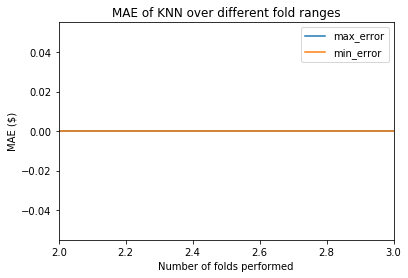

In [6]:
sys.setrecursionlimit(1000)

house_prices_regressor = KNNRegressor(csv_file='./king_county_data_geocoded.csv', nrows=100)

house_prices_regressor.plot_error_rates_for_k_folds(4)

tada()

## Trying the official script

In [6]:
import warnings
warnings.filterwarnings("ignore")

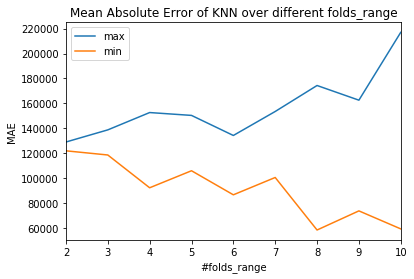

In [7]:
%run regression.py

tada()

In [ ]:
def main():
    

In [17]:
def main():
    regression_test = RegressionTest()
    regression_test.load_csv_file('king_county_data_geocoded.csv', 1000)
    regression_test.plot_error_rates()

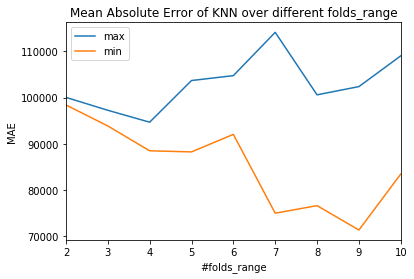

In [18]:
main()

tada()

In [21]:
def main2():
    regression_test = RegressionTest()
    regression_test.load_csv_file('king_county_data_geocoded.csv', 100)
    regression_test.plot_error_rates()

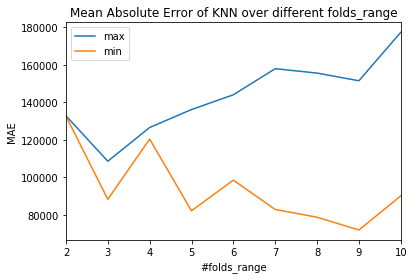

In [22]:
main2()

tada()

In [23]:
def main3():
    regression_test = RegressionTest()
    regression_test.load_csv_file('king_county_data_geocoded.csv', 10000)
    regression_test.plot_error_rates()

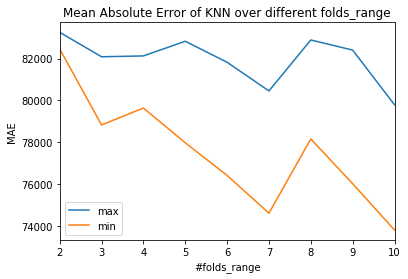

In [24]:
main3()

tada()

***
## [References](./references.md)